In [1]:
import pandas as pd 
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import seaborn
from CreditScore_LR import logistic_score_card
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import time
plt.rc('font', family='SimHei', size=13)
import matplotlib.pyplot as plt
import logging
from sklearn.model_selection import train_test_split
from tqdm import tqdm
# from tqdm import tqdm_notebook as tqdm
from math import log

# 导入数据以及文件保存

In [10]:
# 数据保存文件夹  路径前加 'r'的原因是windows系统问题
train_data_filename = r'../../数据集/train_user_model_feat.csv'  # 训练集数据文件地址
test_data_filename = r'../../数据集/test_user_model_feat.csv'  # 测试集数据文件地址
# 线上数据文件地址（需要预测的数据）
online_data_filename = r'../../数据集/online_user_model_feat.csv'
# 训练模型过程中保存的信息
iv_graph_filename = r'../../LR模型/信用评分卡模型/iv_image'  # 各变量iv值图片保存地址
lr_model_filename = r'../../LR模型/信用评分卡模型/model'  # 逻辑回归模型保存文件
lr_auc_ks_filename = r'../../LR模型/信用评分卡模型/auc_ks_image'  # 模型评价指标图片保存文件

In [11]:
# 查看数据前几行
df_train=pd.read_csv(train_data_filename)

In [13]:
df_train.columns

Index(['user_id', 'y', 'rule_uid', 'user_lv_cd', 'reg_tm_dist', 'last_tm_dist',
       'login_tm_dist', 'uc_last_tm_dist', 'user_total_login_cnt',
       'user_date_cnt_b7day', 'user_date_cnt_b15day', 'uc_date_cnt_b7day',
       'uc_date_cnt_b15day', 'date_ratio_7', 'date_ratio_15',
       'uc_date_ratio_7', 'uc_date_ratio_15', 'user_act_totalCnt',
       'user_act_totalCnt_7day', 'user_act_totalCnt_15day',
       'uc_act_totalCnt_7day', 'uc_act_totalCnt_15day', 'uc_act_totalCnt',
       'uc_act_ratio_7day', 'uc_act_ratio_15day', 'uc_act_ratio_60day',
       'max_click', 'freq_click', 'uc_act_time_1day', 'user_act_time_1day',
       'ratio_act_time_1day', 'uc_act_time_2day', 'user_act_time_2day',
       'ratio_act_time_2day', 'uc_act_time_3day', 'user_act_time_3day',
       'ratio_act_time_3day', 'uc_act_time_5day', 'user_act_time_5day',
       'ratio_act_time_5day', 'uc_act_time_7day', 'user_act_time_7day',
       'ratio_act_time_7day', 'uc_act_decay_1', 'uc_act_decay_2',
       'uc_a

In [12]:
df_train.head()

,user_id,y,rule_uid,user_lv_cd,reg_tm_dist,last_tm_dist,login_tm_dist,uc_last_tm_dist,user_total_login_cnt,user_date_cnt_b7day,...,ratio_indegree_2day,uc_indegree_3day,indegree_total_3day,ratio_indegree_3day,uc_indegree_5day,indegree_total_5day,ratio_indegree_5day,uc_indegree_7day,indegree_total_7day,ratio_indegree_7day
0,289758,0,0,2,214,186004,607340,186004,3,2,...,NaN,5.0,5.0,1.000000,5.0,5.0,1.000000,7,7,1.000000
1,246132,0,0,3,676,604759,2616425,604759,7,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,4,1.000000
2,231004,0,0,3,1742,521480,4672076,521480,7,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27,27,1.000000
3,205700,0,0,2,24,463082,2026429,463082,8,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33,33,1.000000
4,207469,0,0,4,1047,9693,2522587,110918,19,5,...,0.057143,2.0,35.0,0.057143,18.0,87.0,0.206897,19,88,0.215909


# 训练模型

In [4]:
#导入训练集、测试集、线上验证集数据
train_dataset = pd.read_csv(train_data_filename,encoding='utf-8')
test_dataset = pd.read_csv(test_data_filename,encoding='utf-8')
online_dataset = pd.read_csv(online_data_filename,encoding='utf-8')

In [7]:
#使用全部数据做训练
# lr = logistic_score_card()
# lr.fit(train_dataset.drop(['user_id'],axis=1))

100%|██████████████████████████████████████████| 15/15 [07:14<00:00, 21.43s/it]
D:\Anaconda\lib\site-packages\ipykernel\__main__.py:407: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# 选取部分数据训练

In [5]:
#样本分布不合理，总样本4W+,y=1的样本只有843，故挑选部分数据（包含所有y=1）训练，加快速度
temp_data = train_dataset.drop(['user_id'],axis=1)
temp_data = temp_data.sort_values(by='y',ascending=False)
temp_data = temp_data.iloc[:2000]
temp_data

,y,rule_uid,user_lv_cd,reg_tm_dist,last_tm_dist,login_tm_dist,uc_last_tm_dist,user_total_login_cnt,user_date_cnt_b7day,user_date_cnt_b15day,...,ratio_indegree_2day,uc_indegree_3day,indegree_total_3day,ratio_indegree_3day,uc_indegree_5day,indegree_total_5day,ratio_indegree_5day,uc_indegree_7day,indegree_total_7day,ratio_indegree_7day
27178,1,0,3,61,14326,5104582,14326,11,3,4,...,1.000000,4.0,4.0,1.000000,11.0,11.0,1.000000,11,11,1.000000
42040,1,1,5,2005,20565,20583,20565,1,1,1,...,1.000000,1.0,1.0,1.000000,1.0,1.0,1.000000,1,1,1.000000
41983,1,0,4,1592,21476,4235965,21523,7,1,1,...,0.600000,3.0,5.0,0.600000,3.0,5.0,0.600000,3,5,0.600000
33872,1,1,3,160,181231,3211711,181699,2,1,1,...,NaN,1.0,2.0,0.500000,1.0,2.0,0.500000,1,2,0.500000
23358,1,0,4,2687,205397,3201614,205397,10,2,3,...,NaN,1.0,1.0,1.000000,1.0,1.0,1.000000,1,1,1.000000
1523,1,0,4,490,1941,3816942,1941,19,4,6,...,1.000000,1.0,1.0,1.000000,2.0,4.0,0.500000,3,33,0.090909
26133,1,0,3,1392,85848,287062,85848,3,3,3,...,1.000000,2.0,2.0,1.000000,3.0,3.0,1.000000,3,3,1.000000
17630,1,0,3,295,328805,1131874,328805,4,3,4,...,NaN,NaN,NaN,NaN,2.0,3.0,0.666667,2,9,0.222222
36552,1,0,5,1563,123075,128589,123075,1,1,1,...,1.000000,7.0,7.0,1.000000,7.0,7.0,1.000000,7,7,1.000000
12545,1,0,4,409,468533,469570,468533,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1.000000


In [6]:
lr = logistic_score_card()
lr.fit(temp_data)

2019 11:00:53 INFO 任务开始。。。
2019 11:00:53 INFO 连续和离散变量划分中。。。
2019 11:00:53 INFO 连续和离散变量划分完成！
2019 11:00:53 INFO 连续变量最优分组进行中。。。
100%|██████████████████████████████████████████| 71/71 [04:15<00:00,  2.05s/it]
2019 11:05:09 INFO 连续变量最优分组完成！
2019 11:05:09 INFO 根据cut离散化连续变量进行中。。。
100%|██████████████████████████████████████████| 70/70 [00:01<00:00, 65.30it/s]
2019 11:05:10 INFO 根据cut离散化连续变量完成！
2019 11:05:10 INFO 计算所有变量IV值进行中。。。
100%|██████████████████████████████████████████| 71/71 [00:01<00:00, 66.05it/s]
2019 11:05:11 INFO 计算所有变量IV值完成！
2019 11:05:11 INFO 数据WOE转化进行中。。。
100%|██████████████████████████████████████████| 71/71 [00:02<00:00, 27.09it/s]
2019 11:05:14 INFO 数据WOE转化完成
2019 11:05:14 INFO 根据IV值大于 0.02 且 相关性小于 0.8 ，以及l1正则选取变量进行中。。。
100%|████████████████████████████████████████| 69/69 [00:00<00:00, 1131.15it/s]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this

# 查看制作好的评分卡

In [7]:
lr.score_card

,col,col_type,iv,cut_point,cut_str,woe,col_coef,lr_intercept,score,woe_num_rate,woe_y_rate
0,login_tm_dist,1,0.540140,1,"(-,225553]",0.000000,-0.598530,-0.097102,0.000000,0.0640,0.867188
1,login_tm_dist,1,0.540140,2,"(225553,273179]",1.235128,-0.598530,-0.097102,53.326411,0.0300,0.166667
2,login_tm_dist,1,0.540140,3,"(273179,1564123]",-1.629984,-0.598530,-0.097102,-70.374249,0.1105,0.778281
3,login_tm_dist,1,0.540140,4,"(1564123,3296997]",-0.140446,-0.598530,-0.097102,-6.063712,0.1890,0.441799
4,login_tm_dist,1,0.540140,5,"(3296997,5145213]",0.272661,-0.598530,-0.097102,11.772085,0.4030,0.343672
5,login_tm_dist,1,0.540140,6,"(5145213,5183126]",0.000000,-0.598530,-0.097102,0.000000,0.0640,0.867188
6,login_tm_dist,1,0.540140,7,"(5183126,+)",1.065039,-0.598530,-0.097102,45.982852,0.2035,0.191646
7,uc_act_decay_2,1,0.636294,1,"(-,0.12980097300000001]",0.487736,-0.513863,-0.097102,18.079104,0.6315,0.296912
8,uc_act_decay_2,1,0.636294,2,"(0.12980097300000001,0.204323896]",-1.533547,-0.513863,-0.097102,-56.844617,0.0335,0.761194
9,uc_act_decay_2,1,0.636294,3,"(0.204323896,0.22909234899999997]",1.785174,-0.513863,-0.097102,66.171796,0.0435,0.103448


# 模型准确性

In [8]:
lr.logistic_auc_ks

{'train': {'auc': 0.9277331676632755, 'ks': 0.699081048898553}}

# AUC/K-S图

2019 11:05:16 INFO 预测用户分数中。。。
2019 11:05:16 INFO 根据cut离散化连续变量进行中。。。
100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 72.29it/s]
2019 11:05:16 INFO 根据cut离散化连续变量完成！
2019 11:05:16 INFO 预测用户分数完成


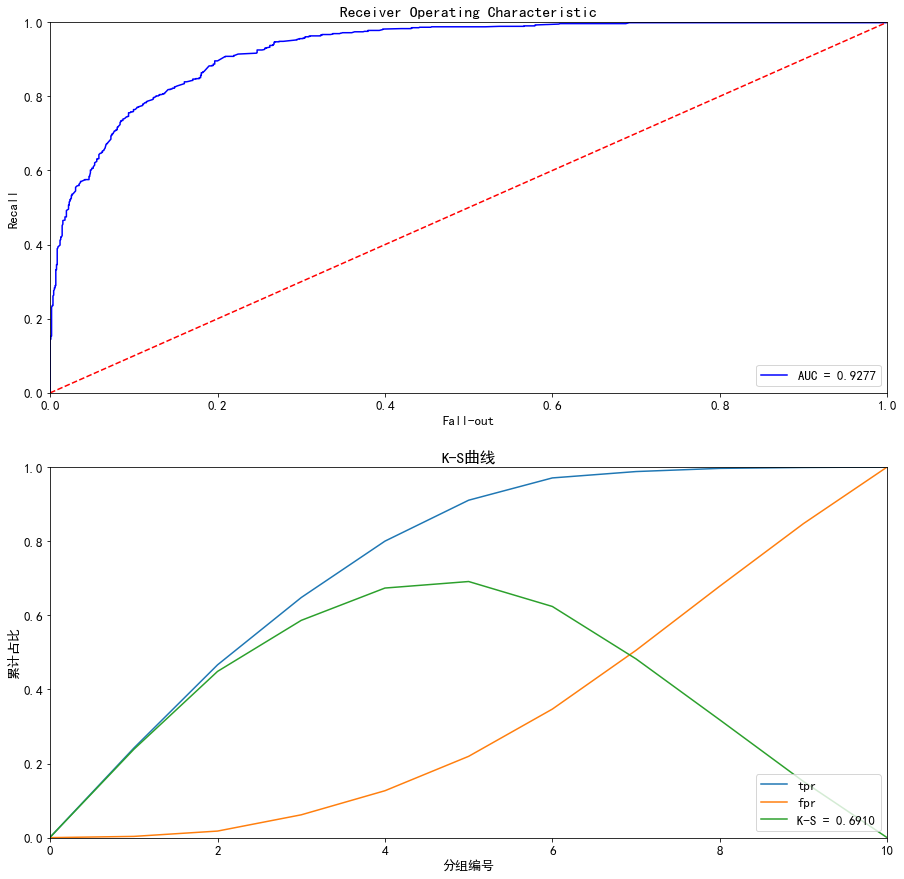

In [9]:
#训练集
lr.plot_roc_ks(temp_data,lr.cut_points_result,lr.score_card)

# 查看个变量IV值

In [12]:
lr.col_type_cut_iv

[['rule_uid', 1, 0.4461046549374675],
 ['user_lv_cd', 1, 0.1201386904159081],
 ['reg_tm_dist', 1, 0.054379406244250895],
 ['last_tm_dist', 1, 1.2208418082643888],
 ['login_tm_dist', 1, 0.5401399539956697],
 ['uc_last_tm_dist', 1, 2.149258575967073],
 ['user_total_login_cnt', 1, 0.9321268733419154],
 ['user_date_cnt_b7day', 1, 0.03932622164847792],
 ['user_date_cnt_b15day', 1, 0.21570939809197642],
 ['uc_date_cnt_b7day', 1, 0.1189585079786756],
 ['uc_date_cnt_b15day', 1, 0.15209061780401384],
 ['date_ratio_7', 1, 0.9767654208905382],
 ['date_ratio_15', 1, 0.7651477358315414],
 ['uc_date_ratio_7', 1, 0.32890433918213746],
 ['uc_date_ratio_15', 1, 0.4401483125116051],
 ['user_act_totalCnt', 1, 0.3742064061600701],
 ['user_act_totalCnt_7day', 1, 0.055279672910054624],
 ['user_act_totalCnt_15day', 1, 0.03805302135435981],
 ['uc_act_totalCnt_7day', 1, 0.3179543881864657],
 ['uc_act_totalCnt_15day', 1, 0.18125660382591746],
 ['uc_act_totalCnt', 1, 0.20158293824290005],
 ['uc_act_ratio_7day', 

# 绘制IV图

2019 11:05:17 INFO ....IV图绘制进行中.....
  0%|                                                   | 0/70 [00:00<?, ?it/s]

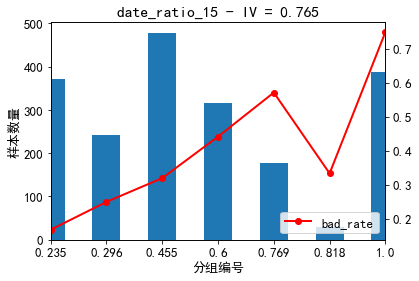

  1%|▌                                          | 1/70 [00:00<00:15,  4.35it/s]

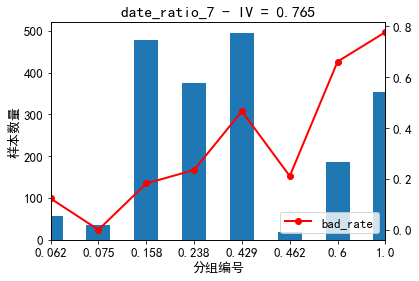

  3%|█▏                                         | 2/70 [00:00<00:15,  4.36it/s]

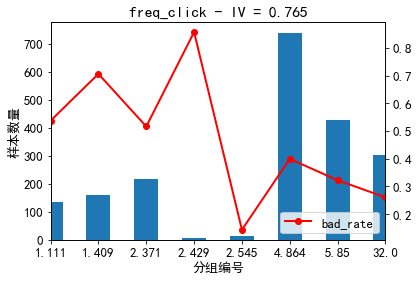

  4%|█▊                                         | 3/70 [00:00<00:15,  4.23it/s]

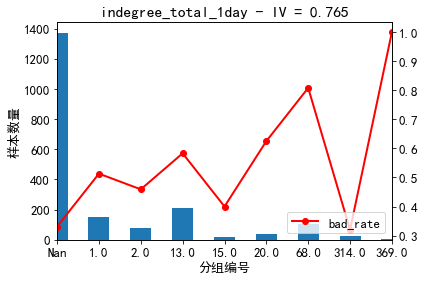

  6%|██▍                                        | 4/70 [00:00<00:16,  4.12it/s]

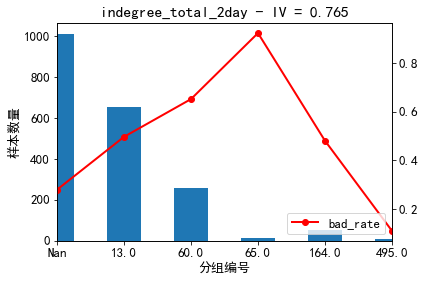

  7%|███                                        | 5/70 [00:01<00:15,  4.23it/s]

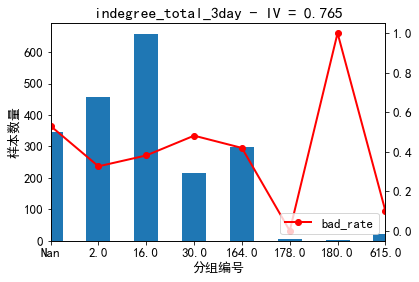

  9%|███▋                                       | 6/70 [00:01<00:15,  4.23it/s]

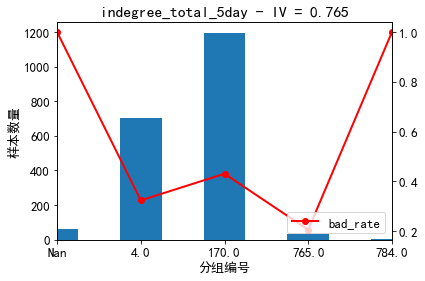

 10%|████▎                                      | 7/70 [00:01<00:14,  4.37it/s]

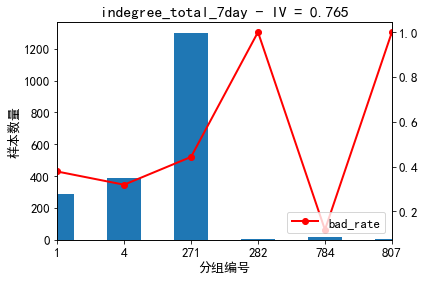

 11%|████▉                                      | 8/70 [00:01<00:14,  4.43it/s]

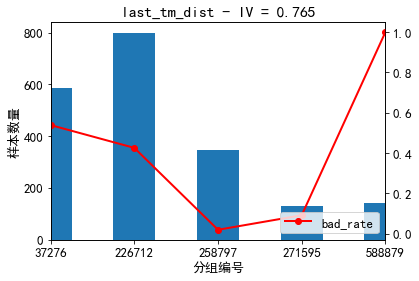

 13%|█████▌                                     | 9/70 [00:02<00:13,  4.55it/s]

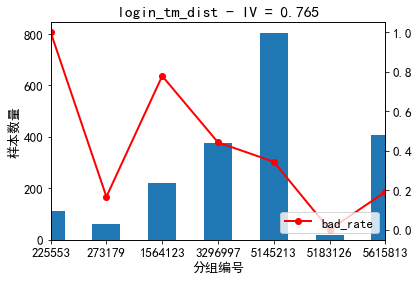

 14%|██████                                    | 10/70 [00:02<00:14,  4.26it/s]

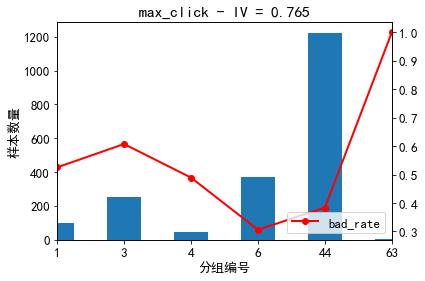

 16%|██████▌                                   | 11/70 [00:02<00:13,  4.32it/s]

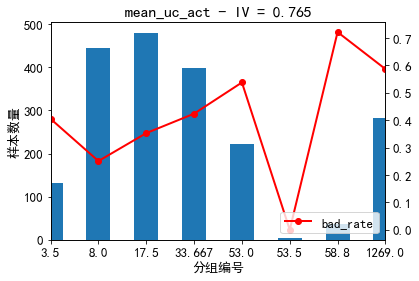

 17%|███████▏                                  | 12/70 [00:02<00:13,  4.29it/s]

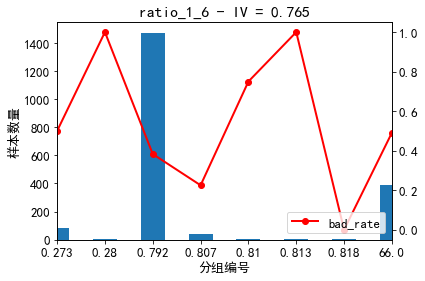

 19%|███████▊                                  | 13/70 [00:03<00:13,  4.26it/s]

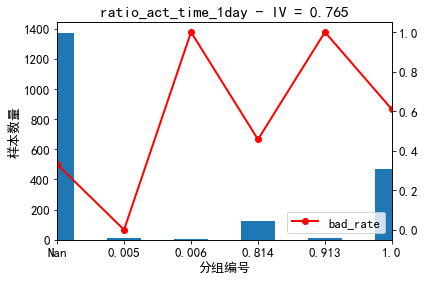

 20%|████████▍                                 | 14/70 [00:03<00:12,  4.33it/s]

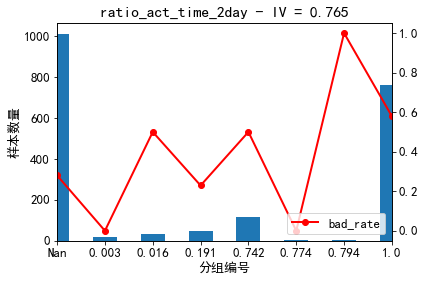

 21%|█████████                                 | 15/70 [00:03<00:12,  4.32it/s]

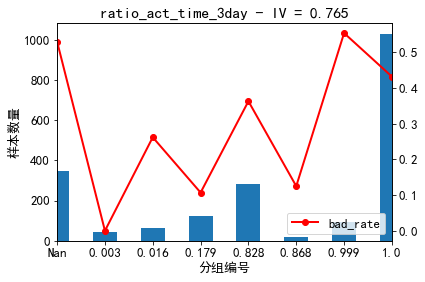

 23%|█████████▌                                | 16/70 [00:03<00:12,  4.32it/s]

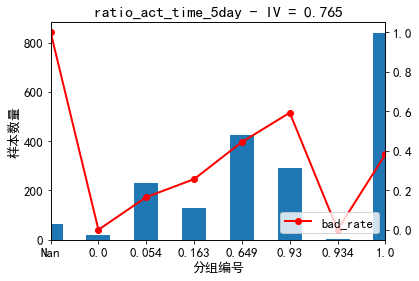

 24%|██████████▏                               | 17/70 [00:04<00:13,  3.99it/s]

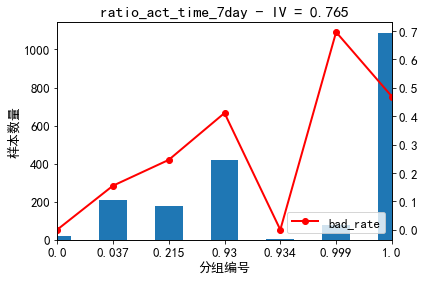

 26%|██████████▊                               | 18/70 [00:04<00:12,  4.08it/s]

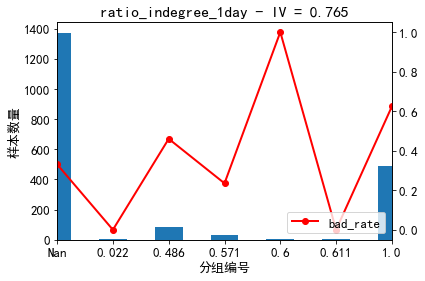

 27%|███████████▍                              | 19/70 [00:04<00:12,  4.14it/s]

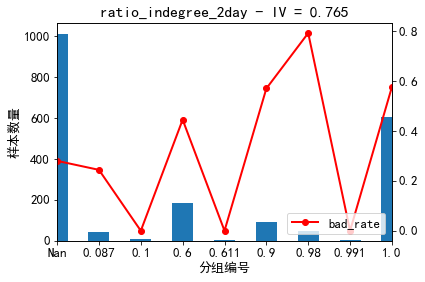

 29%|████████████                              | 20/70 [00:04<00:11,  4.18it/s]

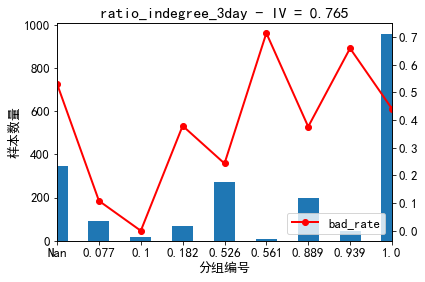

 30%|████████████▌                             | 21/70 [00:05<00:12,  3.88it/s]

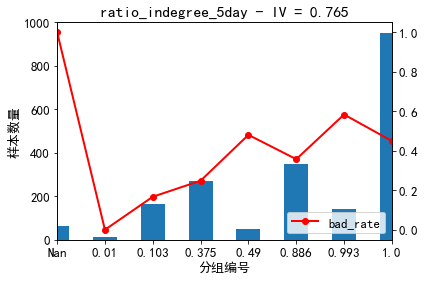

 31%|█████████████▏                            | 22/70 [00:05<00:11,  4.02it/s]

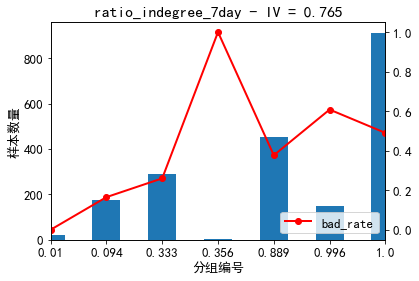

 33%|█████████████▊                            | 23/70 [00:05<00:11,  4.16it/s]

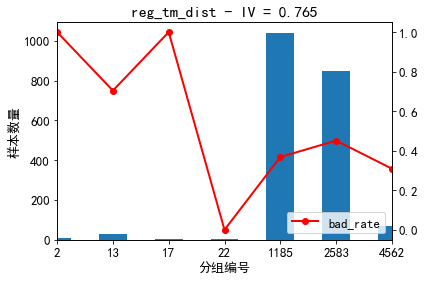

 34%|██████████████▍                           | 24/70 [00:05<00:10,  4.25it/s]

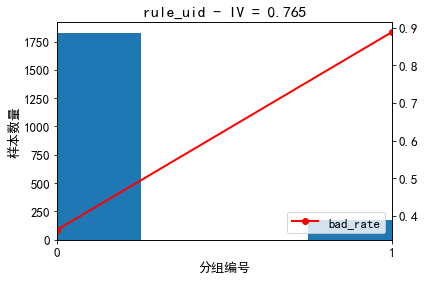

 36%|███████████████                           | 25/70 [00:05<00:09,  4.52it/s]

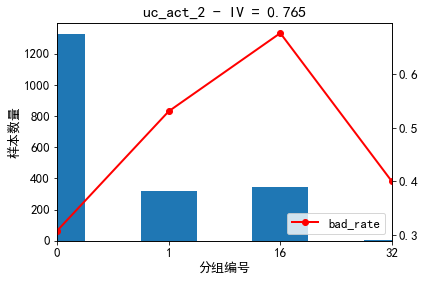

 37%|███████████████▌                          | 26/70 [00:06<00:09,  4.67it/s]

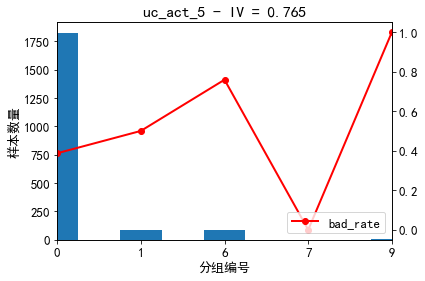

 39%|████████████████▏                         | 27/70 [00:06<00:09,  4.70it/s]

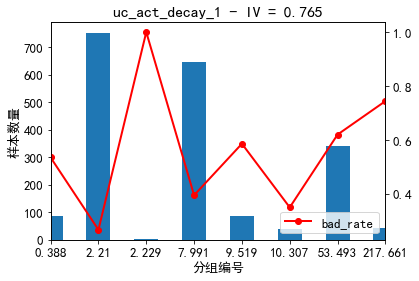

 40%|████████████████▊                         | 28/70 [00:06<00:09,  4.57it/s]

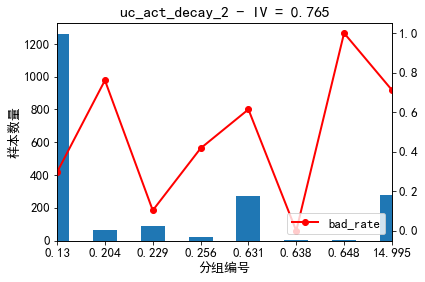

 41%|█████████████████▍                        | 29/70 [00:06<00:09,  4.43it/s]

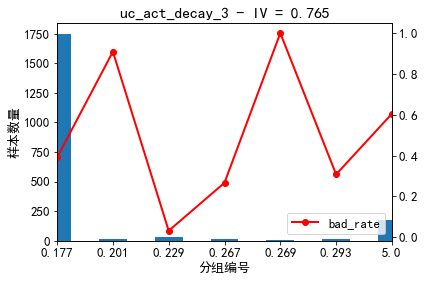

 43%|██████████████████                        | 30/70 [00:06<00:09,  4.36it/s]

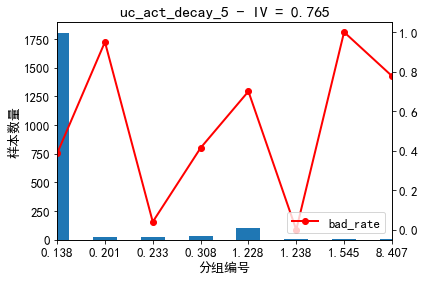

 44%|██████████████████▌                       | 31/70 [00:07<00:09,  4.30it/s]

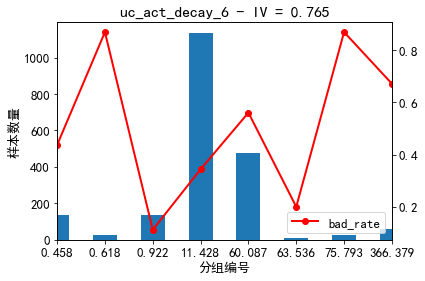

 46%|███████████████████▏                      | 32/70 [00:07<00:09,  4.04it/s]

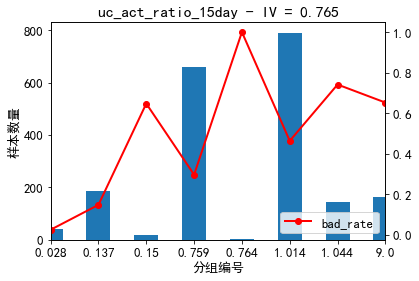

 47%|███████████████████▊                      | 33/70 [00:07<00:08,  4.13it/s]

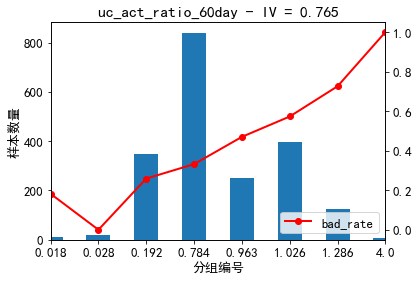

 49%|████████████████████▍                     | 34/70 [00:07<00:08,  4.19it/s]

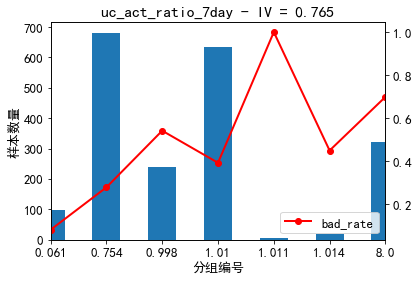

 50%|█████████████████████                     | 35/70 [00:08<00:08,  4.24it/s]

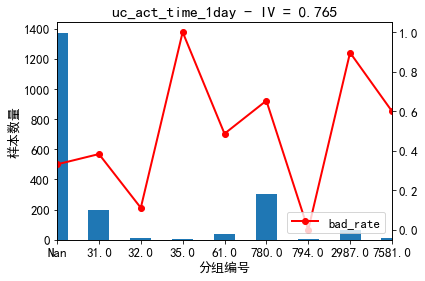

 51%|█████████████████████▌                    | 36/70 [00:08<00:08,  4.21it/s]

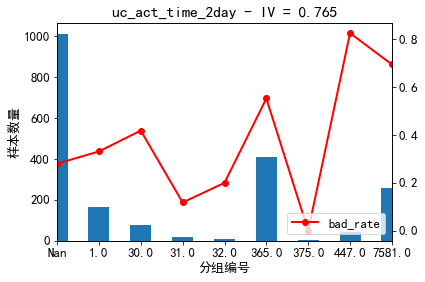

 53%|██████████████████████▏                   | 37/70 [00:08<00:07,  4.21it/s]

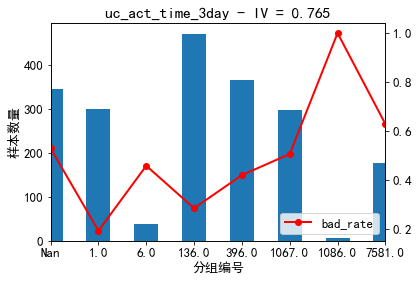

 54%|██████████████████████▊                   | 38/70 [00:08<00:07,  4.26it/s]

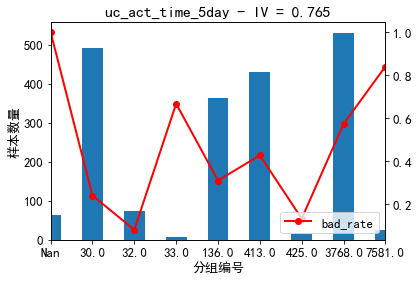

 56%|███████████████████████▍                  | 39/70 [00:09<00:07,  4.23it/s]

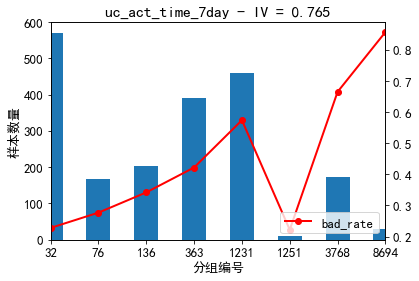

 57%|████████████████████████                  | 40/70 [00:09<00:07,  4.23it/s]

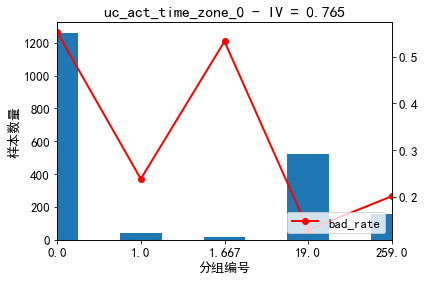

 59%|████████████████████████▌                 | 41/70 [00:09<00:06,  4.37it/s]

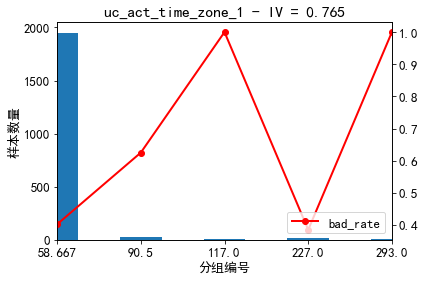

 60%|█████████████████████████▏                | 42/70 [00:09<00:06,  4.48it/s]

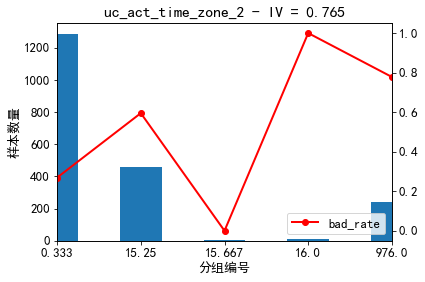

 61%|█████████████████████████▊                | 43/70 [00:10<00:06,  4.25it/s]

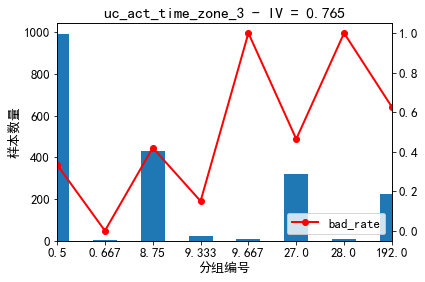

 63%|██████████████████████████▍               | 44/70 [00:10<00:06,  4.28it/s]

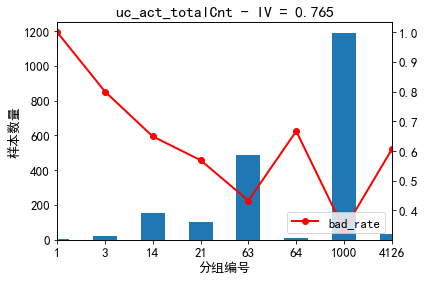

 64%|███████████████████████████               | 45/70 [00:10<00:05,  4.25it/s]

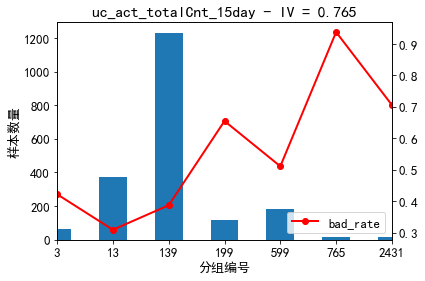

 66%|███████████████████████████▌              | 46/70 [00:10<00:05,  4.26it/s]

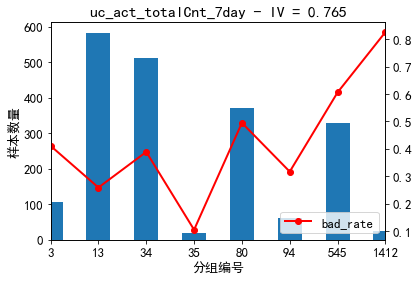

 67%|████████████████████████████▏             | 47/70 [00:11<00:05,  4.21it/s]

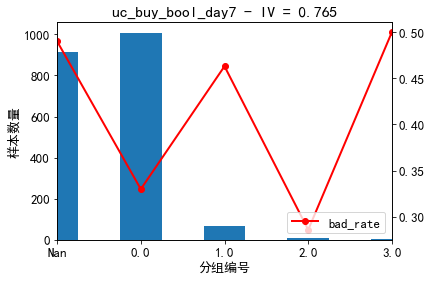

 69%|████████████████████████████▊             | 48/70 [00:11<00:05,  4.40it/s]

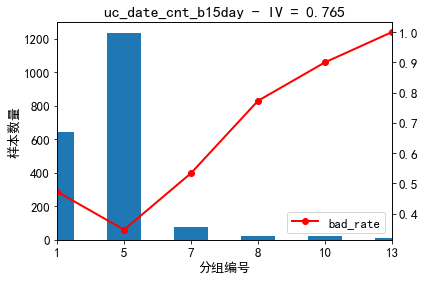

 70%|█████████████████████████████▍            | 49/70 [00:11<00:04,  4.44it/s]

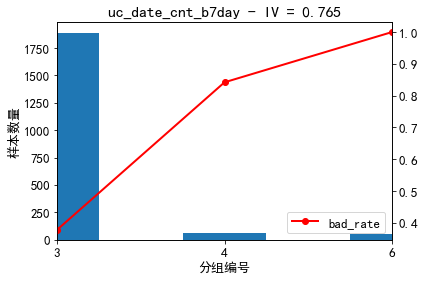

 71%|██████████████████████████████            | 50/70 [00:11<00:04,  4.58it/s]

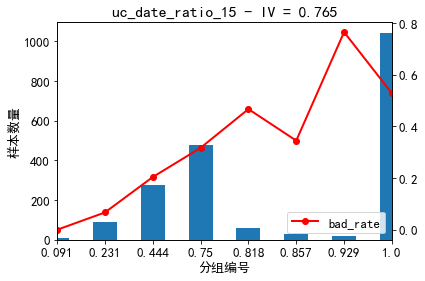

 73%|██████████████████████████████▌           | 51/70 [00:11<00:04,  4.52it/s]

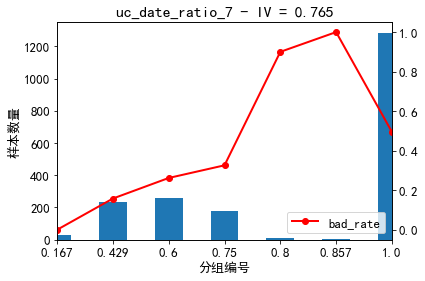

 74%|███████████████████████████████▏          | 52/70 [00:12<00:04,  4.47it/s]

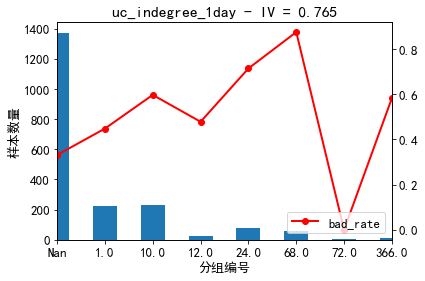

 76%|███████████████████████████████▊          | 53/70 [00:12<00:03,  4.43it/s]

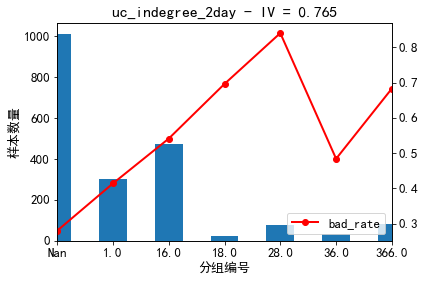

 77%|████████████████████████████████▍         | 54/70 [00:12<00:03,  4.12it/s]

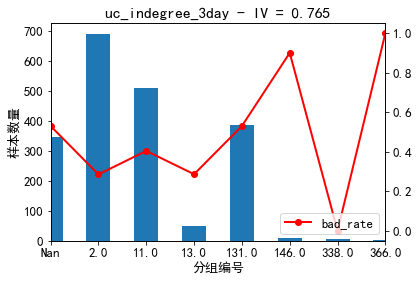

 79%|█████████████████████████████████         | 55/70 [00:12<00:03,  4.13it/s]

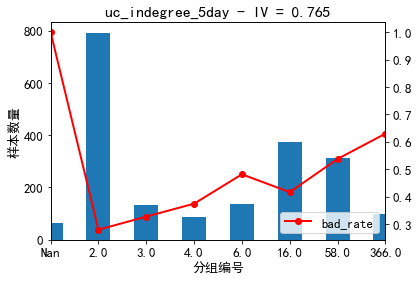

 80%|█████████████████████████████████▌        | 56/70 [00:13<00:03,  4.16it/s]

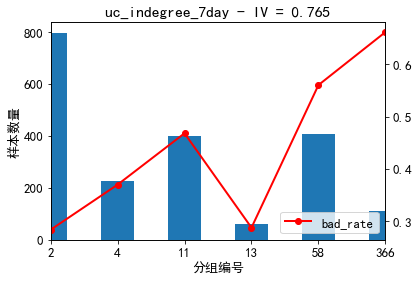

 81%|██████████████████████████████████▏       | 57/70 [00:13<00:02,  4.35it/s]

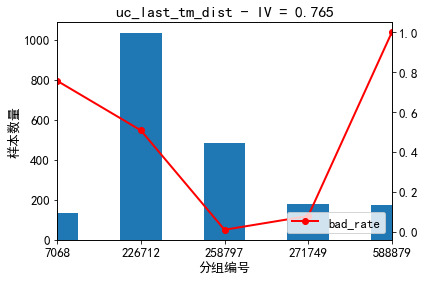

 83%|██████████████████████████████████▊       | 58/70 [00:13<00:02,  4.48it/s]

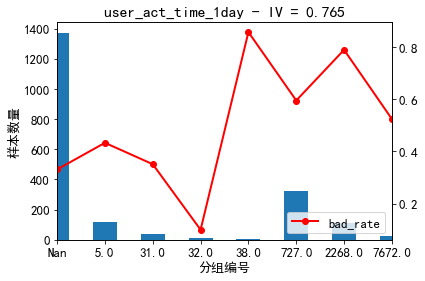

 84%|███████████████████████████████████▍      | 59/70 [00:13<00:02,  4.42it/s]

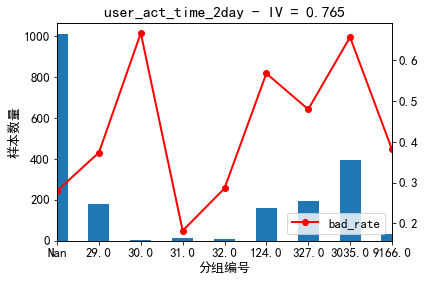

 86%|████████████████████████████████████      | 60/70 [00:13<00:02,  4.35it/s]

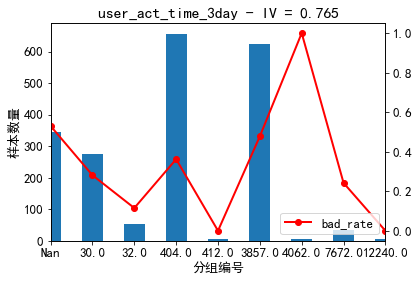

 87%|████████████████████████████████████▌     | 61/70 [00:14<00:02,  4.28it/s]

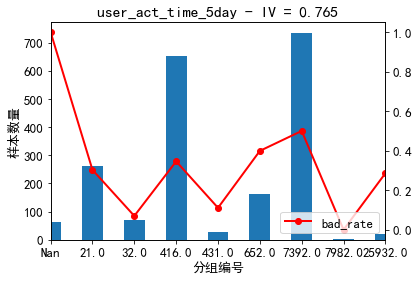

 89%|█████████████████████████████████████▏    | 62/70 [00:14<00:01,  4.22it/s]

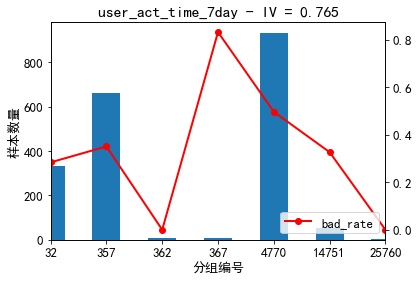

 90%|█████████████████████████████████████▊    | 63/70 [00:14<00:01,  4.33it/s]

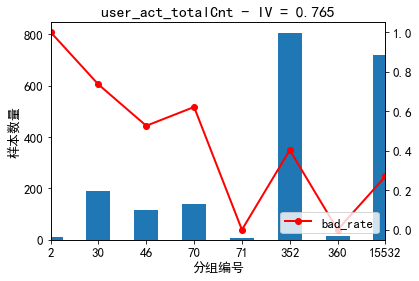

 91%|██████████████████████████████████████▍   | 64/70 [00:14<00:01,  4.36it/s]

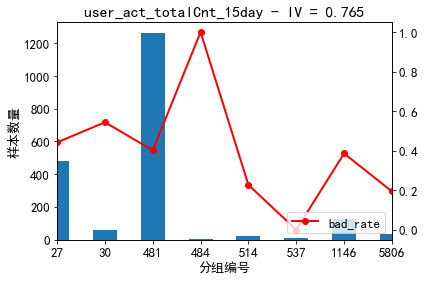

 93%|███████████████████████████████████████   | 65/70 [00:15<00:01,  4.05it/s]

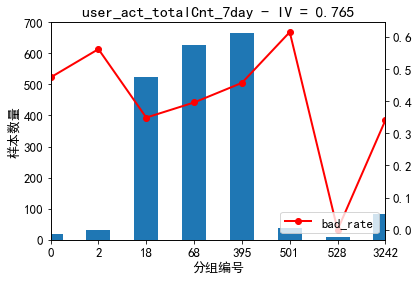

 94%|███████████████████████████████████████▌  | 66/70 [00:15<00:00,  4.08it/s]

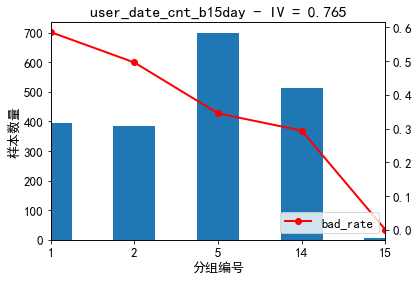

 96%|████████████████████████████████████████▏ | 67/70 [00:15<00:00,  4.21it/s]

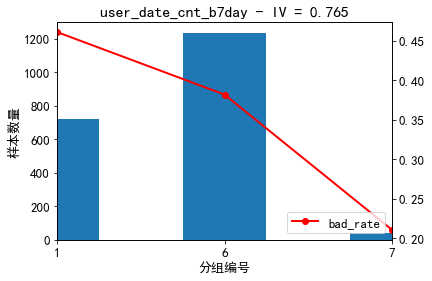

 97%|████████████████████████████████████████▊ | 68/70 [00:15<00:00,  4.44it/s]

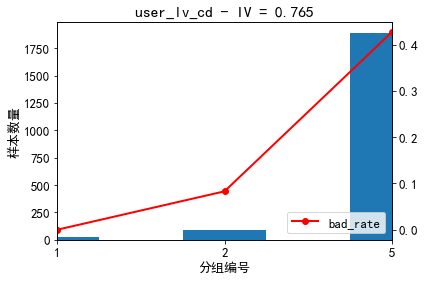

 99%|█████████████████████████████████████████▍| 69/70 [00:16<00:00,  4.62it/s]

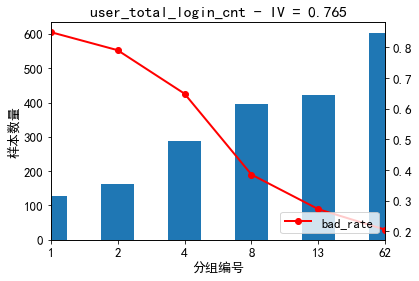

100%|██████████████████████████████████████████| 70/70 [00:16<00:00,  4.58it/s]


In [10]:
lr.plot_iv_graph(temp_data,path = iv_graph_filename)

# 入模变量信息

In [13]:
lr.col_result

['login_tm_dist',
 'uc_last_tm_dist',
 'user_total_login_cnt',
 'uc_act_decay_2',
 'uc_act_time_zone_0',
 'uc_act_time_zone_2']

# 各变量切分点

In [14]:
lr.cut_points_result

[['date_ratio_15',
  [0.235294118,
   0.296296296,
   0.454545455,
   0.6,
   0.7692307690000001,
   0.818181818,
   1.0]],
 ['date_ratio_7',
  [0.0625,
   0.075,
   0.15789473699999998,
   0.23809523800000001,
   0.428571429,
   0.46153846200000004,
   0.6,
   1.0]],
 ['freq_click',
  [1.111111111,
   1.4090909090000001,
   2.370967742,
   2.4285714290000002,
   2.545454545,
   4.8636363639999995,
   5.85,
   32.0]],
 ['indegree_total_1day', [1.0, 2.0, 13.0, 15.0, 20.0, 68.0, 314.0, 369.0]],
 ['indegree_total_2day', [13.0, 60.0, 65.0, 164.0, 495.0]],
 ['indegree_total_3day', [2.0, 16.0, 30.0, 164.0, 178.0, 180.0, 615.0]],
 ['indegree_total_5day', [4.0, 170.0, 765.0, 784.0]],
 ['indegree_total_7day', [1, 4, 271, 282, 784, 807]],
 ['last_tm_dist', [37276, 226712, 258797, 271595, 588879]],
 ['login_tm_dist',
  [225553, 273179, 1564123, 3296997, 5145213, 5183126, 5615813]],
 ['max_click', [1, 3, 4, 6, 44, 63]],
 ['mean_uc_act', [3.5, 8.0, 17.5, 33.66666667, 53.0, 53.5, 58.8, 1269.0]],
 ['

# 测试集数据验证

In [15]:
#测试集
test_data = test_dataset.drop(['user_id'],axis=1)
test_data = test_data.sort_values(by='y',ascending=False)
test_data = test_data.iloc[:3000]

#测试结果(之所以前后KS变化如此之大，是因为样本选取的问题)
lr.score(test_data,lr.cut_points_result,lr.score_card)

2019 10:56:50 INFO 预测用户分数中。。。
2019 10:56:50 INFO 根据cut离散化连续变量进行中。。。
100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 57.14it/s]
2019 10:56:50 INFO 根据cut离散化连续变量完成！
2019 10:56:50 INFO 预测用户分数完成


{'auc': 0.7174941074361177, 'ks': 0.33731418214616965}

2019 10:58:35 INFO 预测用户分数中。。。
2019 10:58:35 INFO 根据cut离散化连续变量进行中。。。
100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 59.41it/s]
2019 10:58:35 INFO 根据cut离散化连续变量完成！
2019 10:58:35 INFO 预测用户分数完成


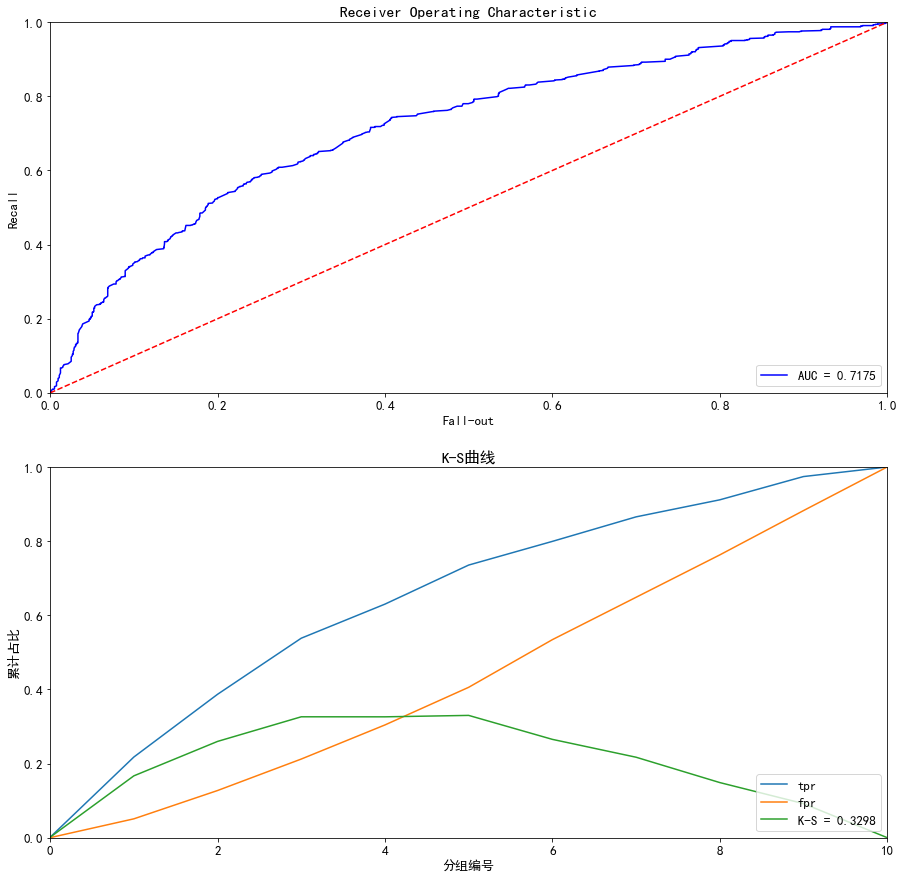

In [16]:
lr.plot_roc_ks(test_data,lr.cut_points_result,lr.score_card)

# 绘制IV图

In [14]:
# lr.plot_iv_graph(data = train_dataset.drop(['user_id'],axis=1),path = iv_graph_filename)

In [15]:
# a = plt.subplots()

In [13]:
import pandas as pd
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import time
plt.rc('font', family='SimHei', size=13)
import matplotlib.pyplot as plt
import logging
from sklearn.model_selection import train_test_split
from tqdm import tqdm
# from tqdm import tqdm_notebook as tqdm
from math import log
# 多线程
from multiprocessing.pool import ThreadPool
from multiprocessing.dummy import Pool
import multiprocessing

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 71.43it/s]


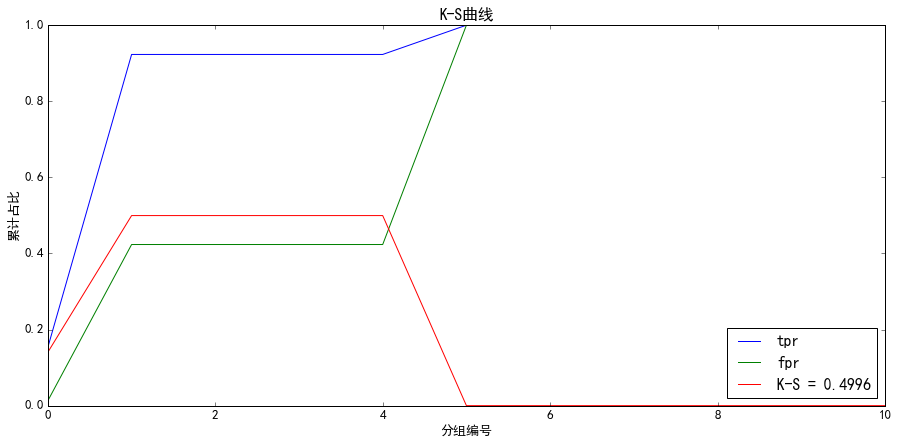

In [15]:
data = temp_data.copy()
data_score_proba = lr.predict_score_proba(data,lr.cut_points_result, lr.score_card)
false_positive_rate, recall, thresholds = roc_curve(data['y'], data_score_proba['proba'],drop_intermediate=False)
roc_auc = auc(false_positive_rate, recall)

plt.figure(figsize=(15, 15))
#KS曲线
plt.subplot(212)
pre = sorted(data_score_proba['proba'], reverse=True)
num = []
for i in range(10):
    num.append((i) * int(len(pre) / 10))
num.append(len(pre) - 1)

df = pd.DataFrame()
df['false_positive_rate'] = false_positive_rate
df['recall'] = recall
df['thresholds'] = thresholds
data_ks = []
for i in num:
    data_ks.append(list(df[df['thresholds'] == pre[i]].values[0]))
data_ks = pd.DataFrame(data_ks)
data_ks.columns = ['fpr', 'tpr', 'thresholds']
ks = max(data_ks['tpr'] - data_ks['fpr'])
plt.title('K-S曲线')
plt.plot(np.array(range(len(num))), data_ks['tpr'])
plt.plot(np.array(range(len(num))), data_ks['fpr'])
plt.plot(np.array(range(len(num))), data_ks['tpr'] - data_ks['fpr'], label='K-S = %0.4f' % ks)
plt.legend(loc='lower right')
plt.xlim([0, 10])
plt.ylim([0.0, 1.0])
plt.ylabel('累计占比')
plt.xlabel('分组编号')

plt.show()

In [24]:
data_score_proba

,user_act_totalCnt_7day,total_score,proba
0,118.018,718.017848,0.003755
1,118.018,718.017848,0.003755
2,118.018,718.017848,0.003755
3,118.018,718.017848,0.003755
4,-33.9207,566.079282,0.030044
5,-33.9207,566.079282,0.030044
6,-33.9207,566.079282,0.030044
7,-72.5792,527.420782,0.050274
8,-33.9207,566.079282,0.030044
9,-33.9207,566.079282,0.030044


In [17]:
max(data_score_proba['proba']),min(data_score_proba['proba'])

(0.1247385559681804, 0.003754975624120638)

In [23]:
len(data['y']),len(data_score_proba['proba']),len(data_score_proba['proba'].drop_duplicates())

(1000, 1000, 4)

In [18]:
len(false_positive_rate), len(recall), len(thresholds)

(5, 5, 5)

In [26]:
thresholds

array([1.12473856, 0.12473856, 0.0502745 , 0.03004377, 0.00375498])

In [27]:
recall

array([0.        , 0.15384615, 0.23076923, 0.92307692, 1.        ])

In [19]:
false_positive_rate

array([0.        , 0.01317123, 0.03546099, 0.42350557, 1.        ])

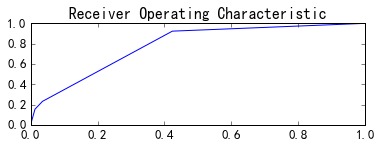

In [25]:
plt.subplot(211)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, recall, 'b', label='AUC = %0.4f' % roc_auc)

# 重新设置K-S图绘制代码

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 66.67it/s]


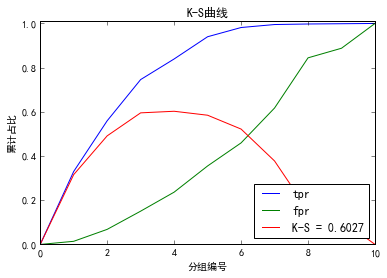

In [79]:
data = temp_data.copy()
data_score_proba = lr.predict_score_proba(data,lr.cut_points_result, lr.score_card)
#将data_score_proba分成10等分，分别计算tpr,fpr
pre_and_true = pd.concat([data[['y']],data_score_proba[['proba']]],axis=1)
pre_and_true = pre_and_true.sort_values(by='proba',ascending=False)
#每个节点对应的TPR,FPR
num_sample = len(pre_and_true)
num_positive = pre_and_true['y'].sum()
num_negative = len(pre_and_true) - num_positive
pre = pre_and_true['proba']
num = []
for i in range(10):
    num.append((i) * int(len(pre) / 10))
num.append(len(pre))
tpr_fpr_list = []
for j in num:
    if j==0:
        tpr=0.0
        fpr=0.0
    else:
        temp = pre_and_true[pre_and_true['proba']>=pre_and_true.iloc[j-1:j]['proba'].values[0]][['y']]
        tp = temp['y'].sum()
        tpr = tp/num_positive
        fp = len(temp) - tp
        fpr = fp/ num_negative
    tpr_fpr_list.append([tpr,fpr])
data_ks = pd.DataFrame(tpr_fpr_list)
data_ks.columns = ['tpr','fpr']
ks = max(data_ks['tpr'] - data_ks['fpr'])
plt.title('K-S曲线')
plt.plot(np.array(range(len(num))), data_ks['tpr'])
plt.plot(np.array(range(len(num))), data_ks['fpr'])
plt.plot(np.array(range(len(num))), data_ks['tpr'] - data_ks['fpr'], label='K-S = %0.4f' % ks)
plt.legend(loc='lower right')
plt.xlim([0, 10])
plt.ylim([0.0, 1.01])
plt.ylabel('累计占比')
plt.xlabel('分组编号')

plt.show()

In [90]:
temp = pre_and_true[pre_and_true['proba']>=pre_and_true.iloc[899:900]['proba'].values[0]][['y']]
len(temp)

937

In [83]:
temp

,y
41421,1
41523,1
41105,1
41252,1
4384,1
31640,1
40549,1
37537,1
25158,1
40978,1


In [80]:
tpr_fpr_list

[[0.0, 0.0],
 [0.3300613496932515, 0.014187643020594966],
 [0.5595092024539877, 0.06819221967963386],
 [0.7460122699386503, 0.1505720823798627],
 [0.8392638036809816, 0.23661327231121282],
 [0.939877300613497, 0.3551487414187643],
 [0.9815950920245399, 0.4594965675057208],
 [0.9950920245398773, 0.6173913043478261],
 [0.9975460122699387, 0.8443935926773455],
 [0.9987730061349693, 0.8878718535469108],
 [1.0, 1.0]]

,fpr,tpr
0,0.000000,0.000000
1,0.384615,0.096251
2,0.461538,0.196555
3,0.692308,0.294833
4,0.846154,0.394124
5,1.000000,0.493414
6,1.000000,0.594732
7,1.000000,0.696049
8,1.000000,0.797366
9,1.000000,0.898683


In [71]:
#按照'prob'排序
pre_and_true = pd.concat([data[['y']],data_score_proba[['proba']]],axis=1)
pre_and_true

,y,proba
0,0,0.003755
1,0,0.003755
2,0,0.003755
3,0,0.003755
4,0,0.030044
5,0,0.030044
6,0,0.030044
7,0,0.050274
8,0,0.030044
9,0,0.030044


In [72]:
pre_and_true = pd.concat([data[['y']],data_score_proba[['proba']]],axis=1)
pre_and_true = pre_and_true.sort_values(by='proba',ascending=False)
#每个节点对应的TPR,FPR
num_sample = len(pre_and_true)
num_positive = pre_and_true['y'].sum()
num_negative = len(pre_and_true) - num_positive
#将dataframe分成10份
pre = pre_and_true['proba']
num = []
for i in range(10):
    num.append((i) * int(len(pre) / 10))
num.append(len(pre))
tpr_fpr_list = []
for j in num:
    if j==0:
        tpr=0.0
        fpr=0.0
    else:
        temp = pre_and_true[pre_and_true['proba']>=pre_and_true.iloc[j-1:j]['proba'].values[0]][['y']]
        tp = pre_and_true.iloc[:j]['y'].sum()
        tpr = tp/num_positive
        fp = len(temp) - tp
        fpr = fp/ num_negative
    tpr_fpr_list.append([tpr,fpr])

In [54]:
pre_and_true.iloc[99:100]['proba'].values[0]

0.030043768915533398

In [73]:
roc_curve(drop_intermediate=False)

[[0.0, 0.0],
 [0.38461538461538464, 0.43059777102330293],
 [0.46153846153846156, 0.42958459979736574],
 [0.6923076923076923, 0.4265450861195542],
 [0.8461538461538461, 0.42451874366767983],
 [1.0, 1.0],
 [1.0, 1.0],
 [1.0, 1.0],
 [1.0, 1.0],
 [1.0, 1.0],
 [1.0, 1.0]]